In [7]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf

from pyvi import ViTokenizer

In [8]:
# init spark session
spark = SparkSession.builder.master('local[*]').config('spark.ui.port', '4040').getOrCreate()
spark

# Overview

In [9]:
review_fp = "hdfs://namenode:9000/review_data/reviews.csv"
df = spark.read.csv(review_fp, header=True, inferSchema=True)

df.printSchema()
print(f'Total reviews: {df.count()}')
df.show(5)

root
 |-- review: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- place_index: integer (nullable = true)

Total reviews: 4016
+--------------------+------+-----------+
|              review|rating|place_index|
+--------------------+------+-----------+
|3 miếng gà 105k n...|     1|          0|
|Thật tuyệt với gà...|     5|          0|
|Gà ướp vừa vị , m...|     5|          0|
|Quán sạch, đẹp, t...|     5|          0|
|Nhân viên bự con ...|     5|          0|
+--------------------+------+-----------+
only showing top 5 rows



Distribution of dataset

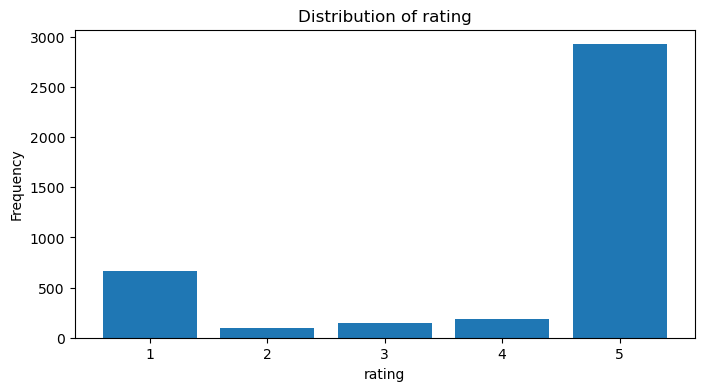

In [10]:
pandas_df = df.groupBy('rating').count().orderBy('rating').toPandas()

figure = plt.figure(figsize=(8, 4))
ax = figure.add_subplot(111)

ax.set_title('Distribution of rating')
ax.bar(pandas_df['rating'], pandas_df['count'])
ax.set_xticks(pandas_df['rating'])
ax.set_xlabel('rating')
ax.set_ylabel('Frequency');

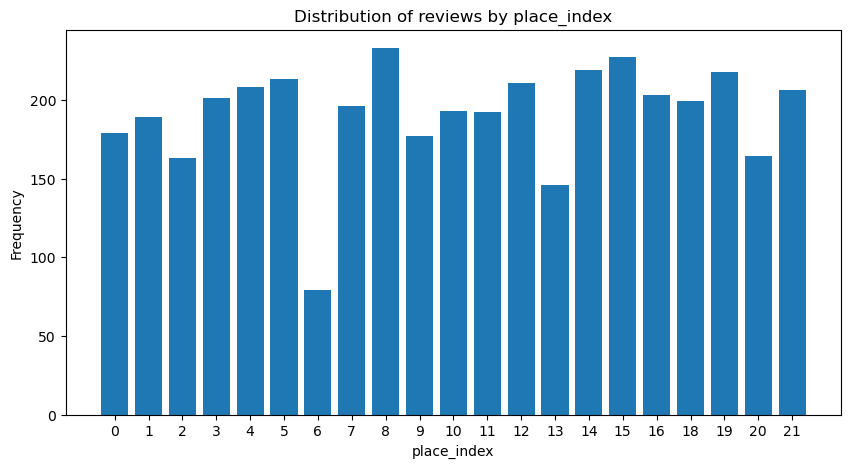

In [17]:
pandas_df = df.groupBy('place_index').count().orderBy('place_index').toPandas()

figure = plt.figure(figsize=(10, 5))
ax = figure.add_subplot(111)

ax.set_title('Distribution of reviews by place_index')
ax.bar(pandas_df.index, pandas_df['count'])
ax.set_xticks(pandas_df.index, labels=pandas_df['place_index'])
ax.set_xlabel('place_index')
ax.set_ylabel('Frequency');

# Encoding Rating into sentiments
Ratings above 3 stars are considered positive, below 3 stars are considered negative and neutral otherwise.

In [18]:
preprocessed_df = df.withColumn("sentiment",
    when(col("rating") > 3, "positive")
    .when(col("rating") == 3, "neutral")
    .otherwise("negative")
)
preprocessed_df.show(5)

+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Thật tuyệt với gà...|     5|          0| positive|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Quán sạch, đẹp, t...|     5|          0| positive|
|Nhân viên bự con ...|     5|          0| positive|
+--------------------+------+-----------+---------+
only showing top 5 rows



In [19]:
preprocessed_df.filter(preprocessed_df['sentiment'] != 'positive').show(5)

+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Khi tôi đặt 5 cán...|     1|          0| negative|
|Gọi gà nướng, bắt...|     1|          0| negative|
|Thanh gà trong co...|     2|          0| negative|
|Đặt hàng trên Sho...|     1|          0| negative|
+--------------------+------+-----------+---------+
only showing top 5 rows



# Abbreviations substiution
List of Vietnamese abbreviations is taken from [`behitek/teencode.txt`](https://gist.github.com/behitek/7d9441c10b3c2739499fc5a4d9ea06fb?fbclid=IwZXh0bgNhZW0CMTEAAR4OyR5hz4Y-r7ubdG_G5gZkWTyOE1J4JoTxFxGbxEGqzvMCUFMn_7bUMcKWjA_aem_uaxRSUlZglhHGEcudhYoSA)

In [20]:
# load dictionary
abbr_fp = 'work/teencode.txt'

ABBREV_DICT = {}
with open(abbr_fp, 'r', encoding='utf-8') as abb:
    for line in abb:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            short, full = parts
            ABBREV_DICT[short] = full

In [21]:
@udf
def replace_abbrev(text: str) -> str:
    if text is None: return None
    return ' '.join(ABBREV_DICT.get(word.lower(), word) for word in text.split())

In [22]:
preprocessed_df = preprocessed_df.withColumn('review', replace_abbrev(preprocessed_df['review']))
preprocessed_df.show(5)

+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Thật tuyệt với gà...|     5|          0| positive|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Quán sạch, đẹp, t...|     5|          0| positive|
|Nhân viên bự con ...|     5|          0| positive|
+--------------------+------+-----------+---------+
only showing top 5 rows



# Vietnamese Word Tokenization

In [23]:
# Define UDF to tokenize using PyVi
@udf
def pyvi_tokenize(text: str) -> str:
    """
    Tokenize Vietnamese text with PyVi.ViTokenizer.
    For more information, see [here]().
    :param str text: The text to tokenize.
    :return: The tokenized text.
    :rtype: str
    """
    return ViTokenizer.tokenize(text)

In [24]:
# Tokenize
preprocessed_df = preprocessed_df.withColumn("review", pyvi_tokenize(col("review")))
preprocessed_df.select('review').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------+
|review                                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------------------------+
|3 miếng gà 105k như này khác gì 2 miếng rưỡi đâu chứ                                                                                             |
|Thật tuyệt với gà vị rất ngon , dịch_vụ chu_đáo , nhiệt_tình và nhanh , nhất_định sẽ đến nhiều lần sau                                           |
|Gà ướp vừa vị , mọng nước . Dù đông nhưng nhân_viên vẫn rất vui_vẻ nhiệt_tình , đồ ăn được phục_vụ nhanh                                         |
|Quán sạch , đẹp , thoáng mát , nhân_viên phục_vụ tận_tình và mấy chị quản_lý rất vui_vẻ với khách              

# Save results and stop session

## Save preprocessed data for EDA and stuff

In [25]:
preprocessed_df.write.parquet(
    'hdfs://namenode:9000/preprocessed'
)

## Train-test split on preprocessed for models training

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    np.arange(preprocessed_df.count()),
    test_size=.2, random_state=4,
    stratify=[row['sentiment'] for row in preprocessed_df.collect()]
)

In [28]:
dataset = preprocessed_df.drop('rating', 'place_index').rdd.zipWithIndex()

train_set = dataset.filter(lambda x: x[1] in train_idx).map(lambda x: x[0])
train_set = train_set.toDF()

test_set = dataset.filter(lambda x: x[1] in test_idx).map(lambda x: x[0])
test_set = test_set.toDF()

train_set.count(), test_set.count()

(3212, 804)

In [32]:
train_set.write.parquet(
    'hdfs://namenode:9000/training_data/train_set'
)
test_set.write.parquet(
    'hdfs://namenode:9000/training_data/test_set'
)

## Stop the session

In [34]:
# Stop session
spark.stop()